<a href="https://colab.research.google.com/github/CherutoSharleen/Data-Science-2/blob/main/Normalization_and_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TODO: Use a specific version of pickle - to avoid getting warnings
# !pip install joblib==1.1.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Feature Selection
from sklearn.feature_selection import SelectFromModel

#Split train and test data
from sklearn.model_selection import train_test_split, KFold, cross_val_score, TimeSeriesSplit

# Data normalization
from sklearn.preprocessing import MinMaxScaler

#For evaluation
#We will use mean absolute and r2 score(should be closer to 1)
from sklearn.metrics import mean_absolute_error, r2_score

#Visualizing the prediction vs tests
import matplotlib.pyplot as plt
import seaborn as sns

# Saving our model
import pickle

## Loading Dataset

In [ ]:
# Load the dataset
bank_data = pd.read_pickle('all_banks.pickle')

In [ ]:
bank_data.head()

Bank Ticker    BAC                                       C                \
Stock Info   Close   High    Low   Open      Volume  Close   High    Low   
Date                                                                       
2006-01-02   46.15  46.36  45.91  46.02         0.0  485.3  487.1  482.2   
2006-01-03   47.08  47.18  46.15  46.92  16197900.0  492.9  493.8  481.1   
2006-01-04   46.58  47.24  46.45  47.00  17427400.0  483.8  491.0  483.5   
2006-01-05   46.64  46.83  46.32  46.58  14668900.0  486.2  487.8  484.0   
2006-01-06   46.57  46.91  46.35  46.80  11965700.0  486.2  489.0  482.0   

Bank Ticker                    ...       MS                             \
Stock Info    Open     Volume  ...    Close     High      Low     Open   
Date                           ...                                       
2006-01-02   483.5        0.0  ...  47.1008  47.3333  46.7107  47.2751   
2006-01-03   490.0  1536700.0  ...  48.4041  48.5535  47.1008  47.4578   
2006-01-04   488.6  1852790.0  ...  48.4373  49.2093  48.4373  48.7278   
2006-01-05   484.4  1015470.0  ...  48.5701  48.6365  48.1634  48.6033   
2006-01-06   488.8  1358930.0  ...  48.6199  48.8524  48.1883  48.7860   

Bank Ticker                WFC                                      
Stock Info      Volume   Close    High     Low    Open      Volume  
Date                                                                
2006-01-02         0.0  31.415  31.535  31.215  31.415         0.0  
2006-01-03   6354408.0  31.900  31.975  31.195  31.600  11015000.0  
2006-01-04   9292188.0  31.530  31.820  31.365  31.800  10594000.0  
2006-01-05   6534262.0  31.495  31.555  31.310  31.500   9927600.0  
2006-01-06   8146445.0  31.680  31.775  31.385  31.580   8324000.0  

[5 rows x 30 columns]

## Selecting BAC Data Only.
<p> I wanted to try out the Random Forest Model


In [ ]:
# Reset the index of the data
bank_data_reset = bank_data.reset_index()
bank_data_reset.head()

Bank Ticker       Date    BAC                                       C         \
Stock Info              Close   High    Low   Open      Volume  Close   High   
0           2006-01-02  46.15  46.36  45.91  46.02         0.0  485.3  487.1   
1           2006-01-03  47.08  47.18  46.15  46.92  16197900.0  492.9  493.8   
2           2006-01-04  46.58  47.24  46.45  47.00  17427400.0  483.8  491.0   
3           2006-01-05  46.64  46.83  46.32  46.58  14668900.0  486.2  487.8   
4           2006-01-06  46.57  46.91  46.35  46.80  11965700.0  486.2  489.0   

Bank Ticker                ...       MS                                        \
Stock Info     Low   Open  ...    Close     High      Low     Open     Volume   
0            482.2  483.5  ...  47.1008  47.3333  46.7107  47.2751        0.0   
1            481.1  490.0  ...  48.4041  48.5535  47.1008  47.4578  6354408.0   
2            483.5  488.6  ...  48.4373  49.2093  48.4373  48.7278  9292188.0   
3            484.0  484.4  ...  48.5701  48.6365  48.1634  48.6033  6534262.0   
4            482.0  488.8  ...  48.6199  48.8524  48.1883  48.7860  8146445.0   

Bank Ticker     WFC                                      
Stock Info    Close    High     Low    Open      Volume  
0            31.415  31.535  31.215  31.415         0.0  
1            31.900  31.975  31.195  31.600  11015000.0  
2            31.530  31.820  31.365  31.800  10594000.0  
3            31.495  31.555  31.310  31.500   9927600.0  
4            31.680  31.775  31.385  31.580   8324000.0  

[5 rows x 31 columns]

In [ ]:
#Flatten columns
# X = df.drop(columns=[('BAC', 'Close'), ('C', 'Close')], axis=1)
# y = df.loc[:, [('BAC', 'Close'), ('C', 'Close')]].mean(axis=1)
BAC_data = bank_data['BAC']
BAC_data.head()
X = BAC_data.drop(('Close'), axis=1)
y = BAC_data.loc[:, ('Close')]

X.head()

Stock Info,High,Low,Open,Volume
Date,,,,
2006-01-02,46.36,45.91,46.02,0.0
2006-01-03,47.18,46.15,46.92,16197900.0
2006-01-04,47.24,46.45,47.00,17427400.0
2006-01-05,46.83,46.32,46.58,14668900.0
2006-01-06,46.91,46.35,46.80,11965700.0


### Trying to see if normalization will improve the performance of the model


In [ ]:
# Save the index of the dataframe
X_index = X.index
X_index

DatetimeIndex(['2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05',
               '2006-01-06', '2006-01-09', '2006-01-10', '2006-01-11',
               '2006-01-12', '2006-01-13',
               ...
               '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
               '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26',
               '2018-04-27', '2018-04-30'],
              dtype='datetime64[ns]', name='Date', length=3216, freq=None)

In [ ]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the DataFrame
scaler.fit(X)

# Transform the DataFrame
normalized_df = scaler.transform(X)

# The resulting DataFrame will have all values between 0 and 1
normalized_df = pd.DataFrame(normalized_df, index=X.index, columns=X.columns)
normalized_df.head()

Stock Info,High,Low,Open,Volume
Date,,,,
2006-01-02,0.830909,0.829604,0.825936,0.000000
2006-01-03,0.846810,0.834194,0.843304,0.013203
2006-01-04,0.847974,0.839931,0.844848,0.014206
2006-01-05,0.840023,0.837445,0.836743,0.011957
2006-01-06,0.841575,0.838019,0.840988,0.009754


### Feature Extraction - Extraction of the date features

In [ ]:
BAC_engineered = X.copy()
BAC_engineered.reset_index(inplace=True)
BAC_engineered.head()

Stock Info,Date,High,Low,Open,Volume
0,2006-01-02,46.36,45.91,46.02,0.0
1,2006-01-03,47.18,46.15,46.92,16197900.0
2,2006-01-04,47.24,46.45,47.00,17427400.0
3,2006-01-05,46.83,46.32,46.58,14668900.0
4,2006-01-06,46.91,46.35,46.80,11965700.0


In [ ]:
# Extract date features from the date columns
date_cols = ['Date']

for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    BAC_engineered['stock_'+date_feature] = getattr(BAC_engineered[col].dt, date_feature)

BAC_engineered.drop(('Date'), axis=1, inplace=True)
BAC_engineered.head()

Stock Info,High,Low,Open,Volume,stock_year,stock_month,stock_day
0,46.36,45.91,46.02,0.0,2006,1,2
1,47.18,46.15,46.92,16197900.0,2006,1,3
2,47.24,46.45,47.00,17427400.0,2006,1,4
3,46.83,46.32,46.58,14668900.0,2006,1,5
4,46.91,46.35,46.80,11965700.0,2006,1,6


##Feature Selection
<p> Used the sklearn lib

In [ ]:

# # Train the model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)

# # Create a SelectFromModel object
# sfm = SelectFromModel(normalized_df, threshold=0.05)

# # # Fit the SelectFromModel object to the data
# sfm.fit(normalized_df, y)


RandomForestRegressor()

In [ ]:
# Print the features that were selected
# selected_features = X.columns[sfm.get_support()]
# print(selected_features)


In [ ]:

# Print feature importance
importance = rf.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.82194
Feature: 1, Score: 0.17087
Feature: 2, Score: 0.00713
Feature: 3, Score: 0.00006


In [ ]:
# plot a correlation matrix
# corr_matrix = BAC_engineered.corr()
# plt.figure(figsize=(14,7))
# sns.heatmap(corr_matrix, cmap=plt.cm.CMRmap, annot=True)
# plt.title("Variables correlations' matrix", pad=25)


Text(0.5, 1.0, "Variables correlations' matrix")

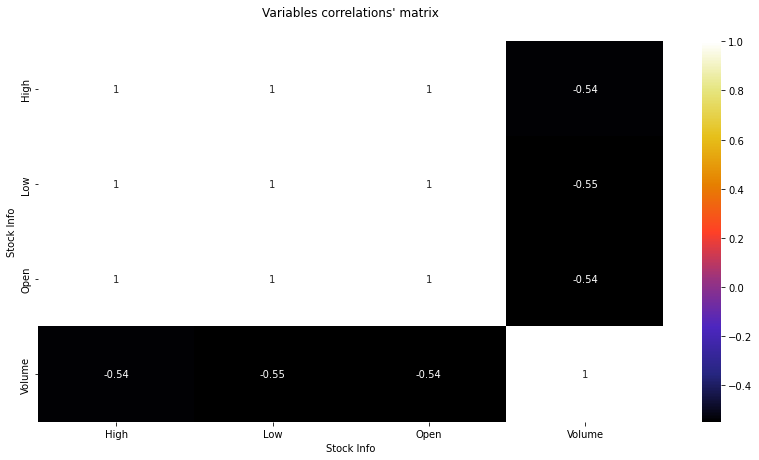

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(14,7))
sns.heatmap(corr_matrix, cmap=plt.cm.CMRmap, annot=True)
plt.title("Variables correlations' matrix", pad=25)

## Split Train and Test Data


<p> I might remove volume and open juu zilirank low...idk

In [ ]:
time_series_instance = TimeSeriesSplit(n_splits = 5)

In [ ]:
for train_index, test_index in time_series_instance.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
X_train.head()

Stock Info,High,Low,Open,Volume
Date,,,,
2006-01-02,46.36,45.91,46.02,0.0
2006-01-03,47.18,46.15,46.92,16197900.0
2006-01-04,47.24,46.45,47.00,17427400.0
2006-01-05,46.83,46.32,46.58,14668900.0
2006-01-06,46.91,46.35,46.80,11965700.0


In [ ]:
# Get the basic pickle model
pickle.dump(rf, open('BAC_base_model.sav', 'wb'))

##Predictions and Evaluation

In [ ]:
# Make predictions on the test data
y_pred = rf.predict(X_test)

In [ ]:

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Calculate the r-squared score
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Absolute Error: ", mae)
print("R-squared score: ", r2)

Mean Absolute Error:  0.050045522388059566
R-squared score:  0.9998351667161203


In [ ]:
# Using cross-validation to get a more accurate mean
kf = KFold(n_splits=5, random_state=42, shuffle=True)
r2_cv = np.mean(cross_val_score(rf, X_test, y_test, cv=kf, scoring='r2'))
mae_cv = np.mean([-i for i in cross_val_score(rf, X_test, y_test, cv=kf, 
                                  scoring='neg_mean_absolute_error')])
mse_cv = np.mean([-i for i in cross_val_score(rf, X_test, y_test, cv=kf, 
                                  scoring='neg_mean_squared_error')])
r2_cv, mae_cv, mse_cv

(0.9988348277811132, 0.13982330564209078, 0.03797997589511905)

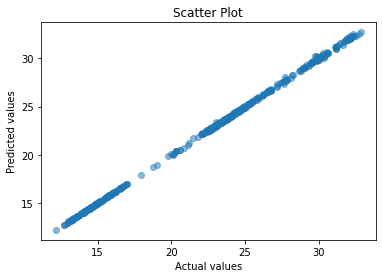

In [ ]:
# Create a scatter plot of the predicted values vs the actual values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Scatter Plot')
plt.show()

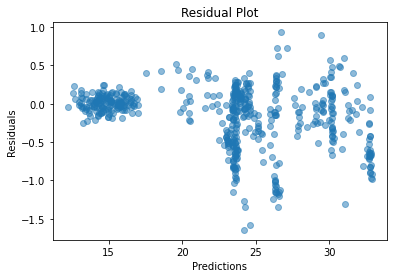

In [ ]:
#Visualize the accuracy using a residual plot
# Residual difference in expected and prediction
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_test - y_pred

# Create a scatter plot of the residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


In [ ]:
#This cell is for predicting user entered data
#Predict User Entered Data
# Get user input

# 44.24	43.8600	44.10	15794500

# high_price = float(input("Enter the high price: "))
# low_price = float(input("Enter the low price: "))
# open_price =  float(input("Enter the opening price: "))
# volume = float(input("Enter the volume: "))

# # Create DF containing the user input
# predict_df = pd.DataFrame(columns=['High', 'Low', 'Open', 'Volume'])
# predict_df.loc['2016-04-20'] = [high_price, low_price, open_price, volume]

# # Create a new list containing the user input
# # new_data = [[open_price, high_price, low_price, volume]]
# # Make a prediction using the trained model
# predicted_price = rf.predict(predict_df)
# predicted_price[0]


## Training using normalized data

In [ ]:
# Split the data into training and testing sets
# 80% train 20% test.
X_train_norm, X_test_norm, y_train_norm, y_test_norm = \
train_test_split(normalized_df, y, test_size=0.2, random_state=42)

X_train_norm.head()

Stock Info,High,Low,Open,Volume
Date,,,,
2016-04-14,0.208842,0.213616,0.202431,0.146201
2006-02-01,0.789800,0.790400,0.788885,0.012875
2012-08-14,0.085127,0.099637,0.087997,0.085299
2009-12-22,0.231336,0.244574,0.234272,0.084824
2012-03-02,0.091138,0.106426,0.094365,0.117288


In [ ]:
# Create an instance of the RandomForestRegressor class
rf_norm = RandomForestRegressor(n_estimators=50, random_state=42)

In [ ]:
# Fit the model to the training data
rf_norm.fit(X_train_norm, y_train_norm)

RandomForestRegressor(random_state=42)

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
r2_cv = np.mean(cross_val_score(rf_norm, X_test_norm, y_test_norm, cv=kf, scoring='r2'))
mae_cv = np.mean([-i for i in cross_val_score(rf_norm, X_test_norm, y_test_norm, cv=kf, 
                                  scoring='neg_mean_absolute_error')])
mse_cv = np.mean([-i for i in cross_val_score(rf_norm, X_test_norm, y_test_norm, cv=kf, 
                                  scoring='neg_mean_squared_error')])
r2_cv, mae_cv, mse_cv

(0.9993451927241445, 0.21328928900193853, 0.13741928610019633)

### Trying out an XGBoost Model

In [ ]:
# Instantiate the XGBoost regressor
xgboost = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, rnadom_state=42)

In [ ]:
# Fit the model to the training data
xgboost.fit(X_train_norm, y_train_norm)

[14:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(rnadom_state=42)

In [ ]:
# Use KFold cross-validation to determine metric values
kf = KFold(n_splits=5, random_state=42, shuffle=True)
r2_cv = np.mean(cross_val_score(xgboost, X_test_norm, y_test_norm, cv=kf, scoring='r2'))
mae_cv = np.mean([-i for i in cross_val_score(xgboost, X_test_norm, y_test_norm, cv=kf, 
                                  scoring='neg_mean_absolute_error')])
mse_cv = np.mean([-i for i in cross_val_score(xgboost, X_test_norm, y_test_norm, cv=kf, 
                                  scoring='neg_mean_squared_error')])
r2_cv, mae_cv, mse_cv

[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

(0.9992792952139296, 0.23648871308708377, 0.15245880645441018)